In [3]:
from utils import db_connect
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
import xgboost as xgb
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import MinMaxScaler
from lazypredict.Supervised import LazyRegressor

In [4]:

# Establecer la conexión a la base de datos
engine = db_connect()

# Verificar si la conexión es exitosa
#if engine:
    #print("Conexión exitosa")

# Consultar la tabla en la base de datos y crear un DataFrame
data = pd.read_sql_table('2019-ABNB', engine)

pd.set_option('display.max_columns', None)  # muestra todas las columnas del dataframe
data.head()



OperationalError: (psycopg2.OperationalError) connection to server at "localhost" (127.0.0.1), port 5432 failed: FATAL:  database "example" does not exist

(Background on this error at: https://sqlalche.me/e/20/e3q8)

In [6]:
data = pd.read_csv('/workspaces/machine-learning-python-template/data/raw/AB_NYC_2019.csv')
data.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.65,-73.97,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75,-73.98,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.81,-73.94,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.69,-73.96,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.80,-73.94,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [7]:
# Mostrar informacion sobre el dataframe
data.shape
data.info()

# En principio vemos que las columna id, host_id se pueden eliminar

# host_name tambien se puede eliminar, ya que de entre todos los anuncios listados (48895), 48874 son distintos, es decir,
#  * solo hay 21 inmuebles que podrían tener el mismo propietario, 0,04% de la muestra. Por tanto, podemos predecir ya que la identidad del propietario no tiene mayor impacto en la cuestion.

# En cuanto a la columna 'name', que vemos que contiene una pequeña descripción, nos encontramos en una situacion parecida, sin embargo,
#  * puesto que se trata de un pequeño 'titular', podemos pensar que no tiene relacion con el precio, pero si es posible que este titular tenga
#  * impacto sobre la demanda, lo que tiene impacto en el precio. 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review                     

In [ ]:

data[['name', 'number_of_reviews', 'price', 'reviews_per_month', 'calculated_host_listings_count']]

# Estudiando las columnas en conjunto podemos concluir que la columna 'name', no tendra practicamente interés para el modelo,
# ya que no oferce informacion relevante y a simplpe vista no parece tener correlacion entre el precio y el numero de visitas.
# Además, sabiendo el mercado del que se trata, es decir inmuebles turísticos de Airbnb, podemos concluír que a la hora de hacer una búsqueda
#  * de alojamiento, el precio y la situación son las principales variables, y que el nombre apenas tiene interés ni llamada al 'click',
#  * y que en todo caso seria da descripcion detallada y sobre todo las fotografía lo que podría inclinar la balanza de la demanda.



,name,number_of_reviews,price,reviews_per_month,calculated_host_listings_count
0,Clean & quiet apt home by the park,9,149,0.21,6
1,Skylit Midtown Castle,45,225,0.38,2
2,THE VILLAGE OF HARLEM....NEW YORK !,0,150,NaN,1
3,Cozy Entire Floor of Brownstone,270,89,4.64,1
4,Entire Apt: Spacious Studio/Loft by central park,9,80,0.10,1
...,...,...,...,...,...
48890,Charming one bedroom - newly renovated rowhouse,0,70,NaN,2
48891,Affordable room in Bushwick/East Williamsburg,0,40,NaN,2
48892,Sunny Studio at Historical Neighborhood,0,115,NaN,1
48893,43rd St. Time Square-cozy single bed,0,55,NaN,6


In [ ]:
data[['number_of_reviews', 'reviews_per_month', 'price']].corr()

,number_of_reviews,reviews_per_month,price
number_of_reviews,1.00,0.55,-0.05
reviews_per_month,0.55,1.00,-0.03
price,-0.05,-0.03,1.00


In [ ]:
data[['number_of_reviews','reviews_per_month', 'last_review']].isnull().mean()*100

# La correlación entre 'number_of_reviews' y 'reviews_per_month' es positiva moderada (0.5499).
# Puesto un mayor número total de reseñas también tengan una tasa de reseñas mensuales más alta, tienen una tasa del 20%, que es un nº considerable,
# y la información que ofrece no es relevante, ya que no tiene apenas correlación con el precio (variable clave), eliminaremos tambien estas columnas.

number_of_reviews    0.00
reviews_per_month   20.56
last_review         20.56
dtype: float64

In [ ]:
data.nunique()

id                                48895
name                              47905
host_id                           37457
host_name                         11452
neighbourhood_group                   5
neighbourhood                       221
latitude                          19048
longitude                         14718
room_type                             3
price                               674
minimum_nights                      109
number_of_reviews                   394
last_review                        1764
reviews_per_month                   937
calculated_host_listings_count       47
availability_365                    366
dtype: int64

In [8]:
data.drop(['id', 'name', 'host_id', 'host_name', 'number_of_reviews','last_review', 'reviews_per_month'], axis=1, inplace=True)
data.head()

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,calculated_host_listings_count,availability_365
0,Brooklyn,Kensington,40.65,-73.97,Private room,149,1,6,365
1,Manhattan,Midtown,40.75,-73.98,Entire home/apt,225,1,2,355
2,Manhattan,Harlem,40.81,-73.94,Private room,150,3,1,365
3,Brooklyn,Clinton Hill,40.69,-73.96,Entire home/apt,89,1,1,194
4,Manhattan,East Harlem,40.80,-73.94,Entire home/apt,80,10,1,0


In [ ]:
# Buscamos duplicados
print(data.duplicated().sum())

# Buscamos valores nulos en todo el conjunto
print(data.isnull().any().any())

data.describe().T

0
False


,count,mean,std,min,25%,50%,75%,max
latitude,48895.00,40.73,0.05,40.50,40.69,40.72,40.76,40.91
longitude,48895.00,-73.95,0.05,-74.24,-73.98,-73.96,-73.94,-73.71
price,48895.00,152.72,240.15,0.00,69.00,106.00,175.00,10000.00
minimum_nights,48895.00,7.03,20.51,1.00,1.00,3.00,5.00,1250.00
calculated_host_listings_count,48895.00,7.14,32.95,1.00,1.00,1.00,2.00,327.00
availability_365,48895.00,112.78,131.62,0.00,0.00,45.00,227.00,365.00


In [9]:
data[data['price'] == 0]
print((data['price'] == 0).sum())
data.drop(data[data['price'] == 0].index, axis=0, inplace=True)

# Observamos que hay 11 inmuebles a precio 0. Esto debe ser un error y es proporcionalmente nimio, limpiamos estas filas.

11


In [10]:
print((data['price'] > 1000).sum())
print(f"{((data['price'] > 1000).sum()) / len(data['price']) * 100}%")
data.drop(data[data['price'] > 1000].index, axis=0, inplace=True)

# Hacemos lo mismo con los inmuebles que valen más de 1000$, que suponen tan solo el 0,5 del conjunto,
# y sería mas efectivo observaros en un modelo 'de lujo'.

239
0.488912527616398%


In [11]:
# Es posible que al filtrar y eliminar algunas filas del DataFrame original usando el método dropna() con inplace=True, el índice del DataFrame no se haya ajustado correctamente,
# lo que puede llevar a que el DataFrame resultante tenga índices adicionales que no corresponden a las filas eliminadas.

data.reset_index(drop=True, inplace=True)  # Restablece el índice del DataFrame después de eliminar filas no deseadas


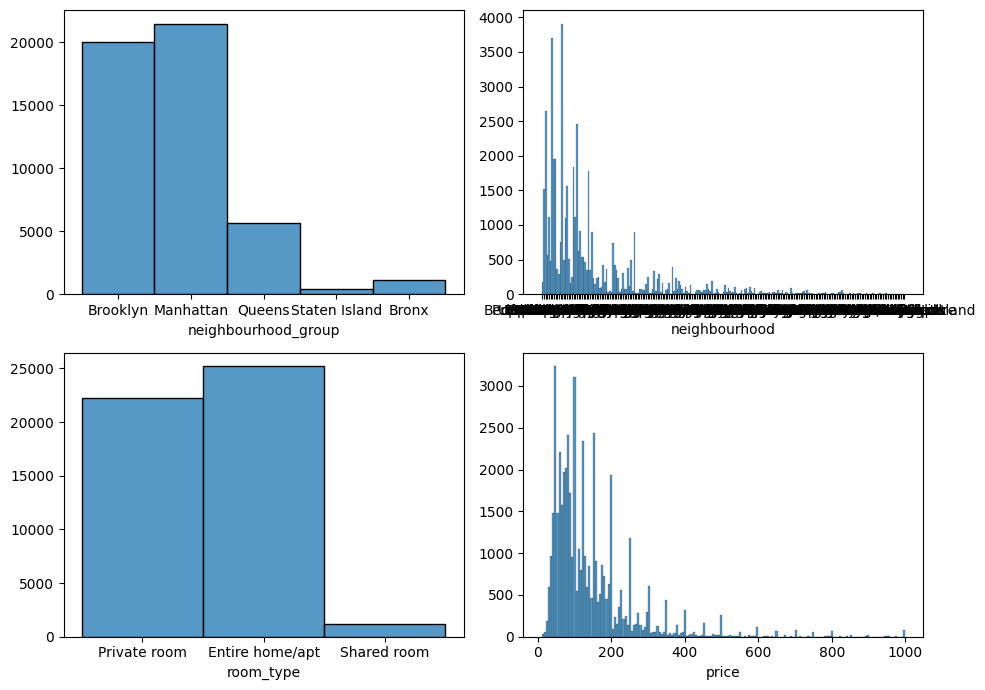

In [12]:
fig, axis = plt.subplots(2, 2, figsize = (10, 7))

# histograma múltiple
sns.histplot(ax = axis[0, 0], data = data, x = "neighbourhood_group").set(ylabel=None)
sns.histplot(ax = axis[0, 1], data = data, x = "neighbourhood").set(ylabel = None)
sns.histplot(ax = axis[1, 0], data = data, x = "room_type").set(ylabel = None)
sns.histplot(ax = axis[1, 1], data = data, x = "price").set(ylabel = None)

# Rotar nombres del eje x en el subplot neighbourhood

#axis[0, 1].set_xticklabels(axis[0, 1].get_xticklabels(), rotation=45)

# Ajustar el layout
plt.tight_layout()

plt.show()

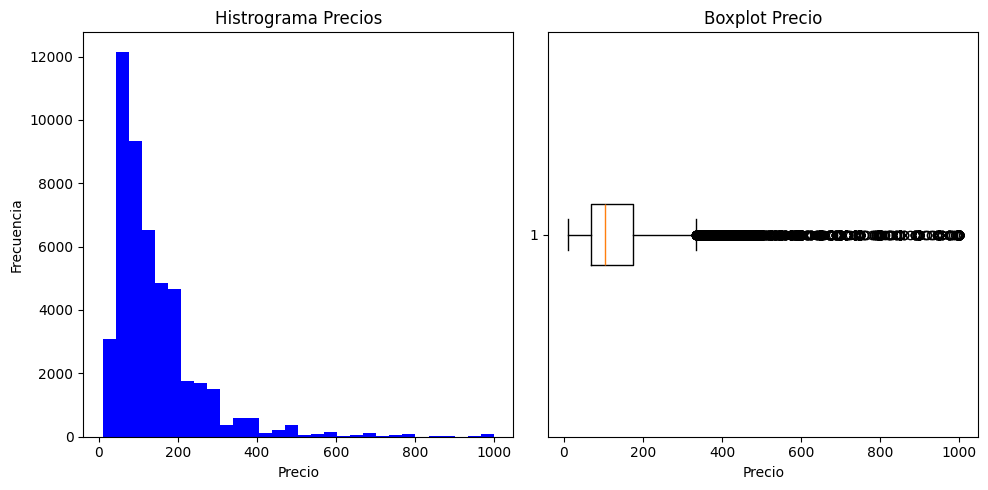

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].hist(data['price'], bins=30, color='blue')
ax[0].set_title("Histrograma Precios")
ax[0].set_xlabel('Precio')
ax[0].set_ylabel('Frecuencia')

ax[1].boxplot(data['price'], vert=False)
ax[1].set_title("Boxplot Precio")
ax[1].set_xlabel("Precio")

plt.tight_layout()
plt.show()

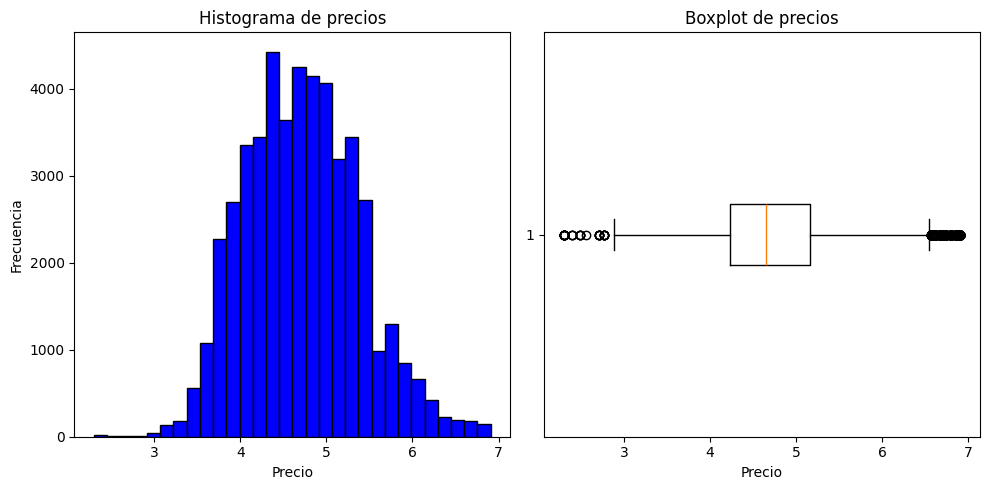

In [ ]:
data['price_log'] = np.log(data.price)

# figura -subplots (histograma y boxplot)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].hist(data['price_log'], bins=30, color='blue', edgecolor='black')
ax[0].set_title('Histograma de precios')
ax[0].set_xlabel('Precio')
ax[0].set_ylabel('Frecuencia')

ax[1].boxplot(data['price_log'], vert=False)
ax[1].set_title('Boxplot de precios')
ax[1].set_xlabel('Precio')

plt.tight_layout()
plt.show()

In [ ]:
# data.info()
# data.nunique()
data['neighbourhood_group']

0         Brooklyn
1        Manhattan
2        Manhattan
3         Brooklyn
4        Manhattan
           ...    
48640     Brooklyn
48641     Brooklyn
48642    Manhattan
48643    Manhattan
48644    Manhattan
Name: neighbourhood_group, Length: 48645, dtype: object

In [ ]:
# * OneHotEncoder: es una clase de scikit-learn que se utiliza para convertir variables categóricas en representaciones numéricas.
# Crea columnas de variables dummy para cada categoría única en la variable categórica original.

# * drop='first': este parámetro se utiliza para evitar la multicolinealidad (cuando dos o más variables predictoras están altamente correlacionadas entre sí).
# En la codificación one-hot, se produce cuando una columna de variables dummy se puede predecir linealmente a partir de las otras columnas de variables dummy. Al especificar drop='first', le decimos a OneHotEncoder que elimine la primera columna de variables dummy para cada característica categórica.
# Esto elimina la multicolinealidad, ya que la primera columna de variables dummy se puede deducir de las otras columnas.

# * sparse=False: eeste parámetro sparse=False se utiliza para indicar que no queremos que el resultado sea una matriz dispersa (sparse matrix)
# Por defecto, OneHotEncoder devuelve una matriz dispersa, que es eficiente en cuanto al uso de memoria cuando hay muchas categorías únicas.
# Sin embargo, en este caso, especificamos sparse=False para obtener una matriz densa, que es más fácil de manejar y manipular en el contexto del análisis y modelado de datos.

In [ ]:

# Columnas a codificar con OneHotEncoder:
# Convertir la Serie en un DataFrame de una sola columna

# columna_onehot = pd.DataFrame(data['room_type'])

# OH_encoder = OneHotEncoder()  # Inicializa el codificador OneHotEncoder

# columna_OH = OH_encoder.fit_transform(columna_onehot) # Columnas que nos interesan codificadas

# nombre_columna_OH = OH_encoder.get_feature_names_out(['room_type'])  # Nombre de las columnas codificadas

# oh_data = pd.DataFrame(columna_OH.toarray(), columns=nombre_columna_OH)  # método toarray() convierte la matriz dispersa resultado de fit_transform()
                                                                            # en una matriz densa, para crear el DataFrame oh_data con la forma correcta.


# Columna a codificar con LabelEncoder:

columnas_etiqueta = ['neighbourhood', 'neighbourhood_group', 'room_type']

label_encoder = LabelEncoder() # Inicializa el codificador LabelEncoder

for columna in columnas_etiqueta:
    data[columna] = label_encoder.fit_transform(data[columna])  # Aplica LabelEncoder a las columnas seleccionadas

# Añadir la columna codificada al DataFrame original
# (dataframe original sin las columnas colificadas + dataframe de las columnas onehot + columnas etiquetada
data_encoded = pd.concat([data.drop(columnas_etiqueta, axis=1), data[columnas_etiqueta]], axis=1)
data_encoded


,latitude,longitude,price,minimum_nights,calculated_host_listings_count,availability_365,price_log,neighbourhood,neighbourhood_group,room_type
0,40.65,-73.97,149,1,6,365,5.00,108,1,1
1,40.75,-73.98,225,1,2,355,5.42,127,2,0
2,40.81,-73.94,150,3,1,365,5.01,94,2,1
3,40.69,-73.96,89,1,1,194,4.49,41,1,0
4,40.80,-73.94,80,10,1,0,4.38,61,2,0
...,...,...,...,...,...,...,...,...,...,...
48640,40.68,-73.95,70,2,2,9,4.25,13,1,1
48641,40.70,-73.93,40,4,2,36,3.69,28,1,1
48642,40.81,-73.95,115,10,1,27,4.74,94,2,0
48643,40.76,-73.99,55,1,6,2,4.01,95,2,2


In [ ]:
# Variables independientes/dependiente
X = data_encoded.drop(['price', 'price_log'], axis=1)
y = data_encoded['price_log']

# Ajusta el modelo
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()

# Instancia de la influencia y obtención de la distancia de cook para cada observación
cooks_distance = model.get_influence().cooks_distance

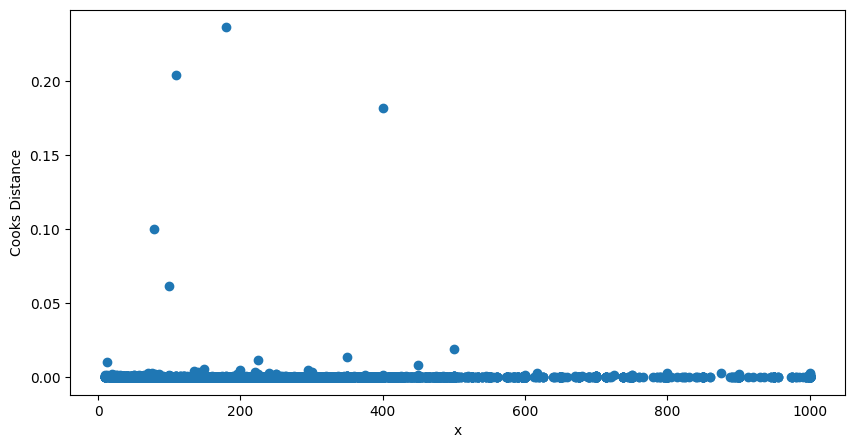

In [ ]:
plt.figure(figsize=(10, 5))
plt.scatter(data.price, cooks_distance[0])
plt.xlabel('x')
plt.ylabel('Cooks Distance')
plt.show()

In [ ]:
np.where(cooks_distance[0]>0.05)
data.iloc[[2843, 5727, 13334, 26211, 38476,]]

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,calculated_host_listings_count,availability_365,price_log
2843,2,6,40.71,-74.02,0,400,1000,1,362,5.99
5727,2,92,40.73,-74.00,0,180,1250,1,365,5.19
13334,2,94,40.83,-73.94,0,99,999,1,42,4.60
26211,1,214,40.72,-73.95,1,79,999,6,249,4.37
38476,2,92,40.73,-74.00,2,110,999,1,365,4.70


In [ ]:
data_encoded.corr()
data[['minimum_nights', 'price']].corr()

,minimum_nights,price
minimum_nights,1.00,0.02
price,0.02,1.00


In [ ]:
data.drop('minimum_nights', axis=1, inplace=True)
data

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,calculated_host_listings_count,availability_365,price_log
0,1,108,40.65,-73.97,1,149,6,365,5.00
1,2,127,40.75,-73.98,0,225,2,355,5.42
2,2,94,40.81,-73.94,1,150,1,365,5.01
3,1,41,40.69,-73.96,0,89,1,194,4.49
4,2,61,40.80,-73.94,0,80,1,0,4.38
...,...,...,...,...,...,...,...,...,...
48640,1,13,40.68,-73.95,1,70,2,9,4.25
48641,1,28,40.70,-73.93,1,40,2,36,3.69
48642,2,94,40.81,-73.95,0,115,1,27,4.74
48643,2,95,40.76,-73.99,2,55,6,2,4.01


In [ ]:
data_encoded.drop('minimum_nights', axis=1, inplace=True)
data_encoded

,latitude,longitude,price,calculated_host_listings_count,availability_365,price_log,neighbourhood,neighbourhood_group,room_type
0,40.65,-73.97,149,6,365,5.00,108,1,1
1,40.75,-73.98,225,2,355,5.42,127,2,0
2,40.81,-73.94,150,1,365,5.01,94,2,1
3,40.69,-73.96,89,1,194,4.49,41,1,0
4,40.80,-73.94,80,1,0,4.38,61,2,0
...,...,...,...,...,...,...,...,...,...
48640,40.68,-73.95,70,2,9,4.25,13,1,1
48641,40.70,-73.93,40,2,36,3.69,28,1,1
48642,40.81,-73.95,115,1,27,4.74,94,2,0
48643,40.76,-73.99,55,6,2,4.01,95,2,2


In [ ]:
# Aplicamos la función skew() a cada columna del DataFrame para calcular su sesgo:

data_encoded.apply(lambda x: x.skew())   # La función skew() calcula el sesgo (skewness) de una distribución de datos.
                                         # El sesgo es una medida de la asimetría de la distribución de datos con respecto a la media.

# Si el sesgo es cero, significa que la distribución es simétrica. 
# Si el sesgo es positivo, la distribución tiene una cola larga hacia la derecha,
# Si es negativo, la cola larga se encuentra hacia la izquierda.

latitude                         0.24
longitude                        1.29
price                            2.94
calculated_host_listings_count   7.92
availability_365                 0.77
price_log                        0.31
neighbourhood                    0.26
neighbourhood_group              0.38
room_type                        0.42
dtype: float64

In [ ]:
# Windsorización: técnica de preprocesamiento de datos que se utiliza para tratar los valores atípicos mediante SU modificación
#  * para que caigan dentro de un rango predefinido, en lugar de eliminarlos por completo.
# Esto ayuda a suavizar la distribución de los datos y a mitigar el efecto de los valores extremos en el análisis estadístico.

In [ ]:
# Convertimos las columnas binarias a int32: 0 y 1 son los únicos valores que contendrán y están dentro del rango de int32
# Ocupa menos memoria

# dtype_c = ['room_type_Entire home/apt',
#           'room_type_Private room',
#          'room_type_Shared room']

# data_encoded[dtype_c] = data_encoded[dtype_c].astype(np.int32)


In [ ]:
data_encoded.isnull().any().any()

False

In [ ]:
# Seleccionamos las columnas no binarias: 
# Se identifican las columnas del DataFrame que contienen valores binarios (0 o 1) y se eliminan del DataFrame.
# La windsorización se aplica típicamente a datos numéricos continuos, y las columnas binarias no requieren windsorización.

binarias = data_encoded.columns[data_encoded.isin([0, 1]).all()]

windsorizar_datos = data_encoded.drop(binarias, axis=1)
windsorizar_datos

,latitude,longitude,price,calculated_host_listings_count,availability_365,price_log,neighbourhood,neighbourhood_group,room_type
0,40.65,-73.97,149,6,365,5.00,108,1,1
1,40.75,-73.98,225,2,355,5.42,127,2,0
2,40.81,-73.94,150,1,365,5.01,94,2,1
3,40.69,-73.96,89,1,194,4.49,41,1,0
4,40.80,-73.94,80,1,0,4.38,61,2,0
...,...,...,...,...,...,...,...,...,...
48640,40.68,-73.95,70,2,9,4.25,13,1,1
48641,40.70,-73.93,40,2,36,3.69,28,1,1
48642,40.81,-73.95,115,1,27,4.74,94,2,0
48643,40.76,-73.99,55,6,2,4.01,95,2,2


In [ ]:
# Función para calcular IQR (rango intercuartílico) y aplicar winsorización

def windsorizar_columnas(column, lower, upper):   # lower, upper: estos parámetro especifican los percentiles inferior y superior usados para calcular el rango intercuartílico (IQR)
    q1 = column.quantile(lower)  # Se calculan los percentiles lower y upper de la columna utilizando el método quantile() de Pandas.
    q3 = column.quantile(upper)
    iqr_value = q3-q1   # El IQR se calcula restando el primer cuartil (q1) del tercer cuartil (q3)

    # Calculamos los límites de windsorizacion: los valores extremos, que están más allá de 1.5 veces el IQR de los cuartiles,
    # se recorten para mitigar su influencia en el análisis estadístico
    lower_limit = q1 - 1.5 * iqr_value    # 1.5 veces el rango intercuartílico (IQR) como criterio para calcular los límites de winsorización 
    upper_limit = q3 + 1.5 * iqr_value    # es un estándar comúnmente aceptado en análisis estadístico 
    
    column = column.clip(lower=lower_limit, upper=upper_limit)  # método clip() de Pandas para recortar los valores de la columna
    return column

# Calcular el IQR y aplicar winsorización a cada columna del dataframe:

for columna in windsorizar_datos.columns:
    windsorizar_datos[columna] = windsorizar_columnas(windsorizar_datos[columna], 0.25, 0.75)


In [ ]:
windsorizar_datos.apply(lambda x: x.skew())

latitude                         0.24
longitude                        0.53
price                            1.03
calculated_host_listings_count   1.15
availability_365                 0.77
price_log                        0.28
neighbourhood                    0.26
neighbourhood_group              0.28
room_type                        0.42
dtype: float64

In [ ]:
data_p = pd.concat([windsorizar_datos, data_encoded[binarias]], axis=1)
data_p

,latitude,longitude,price,calculated_host_listings_count,availability_365,price_log,neighbourhood,neighbourhood_group,room_type
0,40.65,-73.97,149,3.50,365,5.00,108,1.00,1
1,40.75,-73.98,225,2.00,355,5.42,127,2.00,0
2,40.81,-73.94,150,1.00,365,5.01,94,2.00,1
3,40.69,-73.96,89,1.00,194,4.49,41,1.00,0
4,40.80,-73.94,80,1.00,0,4.38,61,2.00,0
...,...,...,...,...,...,...,...,...,...
48640,40.68,-73.95,70,2.00,9,4.25,13,1.00,1
48641,40.70,-73.93,40,2.00,36,3.69,28,1.00,1
48642,40.81,-73.95,115,1.00,27,4.74,94,2.00,0
48643,40.76,-73.99,55,3.50,2,4.01,95,2.00,2


In [ ]:
data['neighbourhood_group'].value_counts()

neighbourhood_group
2    21488
1    20041
3     5656
0     1089
4      371
Name: count, dtype: int64

In [ ]:
# demanda muy alta - 1
# damanda alta - 2
# demanda media - 3
# demanda baja - 4
# demanda muy baja - 5


def demanda(n_huespedes, barrio):
    if barrio == 2 and n_huespedes >= 1:
        return 1
    elif barrio == 1 and n_huespedes >= 2:
        return 1
    elif barrio == 1 and n_huespedes == 1:
        return 2
    elif (barrio == 3 or 
          barrio == 0 or 
          barrio == 4) and n_huespedes > 2:
        return "3"
    elif barrio == 3 and n_huespedes <= 2:
        return "4"
    elif (barrio == 4 or 
          barrio == 0) and n_huespedes <= 2:
        return "5"

# Aplicar la función a cada fila del DataFrame
data_p['demanda'] = data_p.apply(lambda row: demanda(row['calculated_host_listings_count'], row['neighbourhood_group']), axis=1)
data_p


,latitude,longitude,price,calculated_host_listings_count,availability_365,price_log,neighbourhood,neighbourhood_group,room_type,demanda
0,40.65,-73.97,149,3.50,365,5.00,108,1.00,1,1
1,40.75,-73.98,225,2.00,355,5.42,127,2.00,0,1
2,40.81,-73.94,150,1.00,365,5.01,94,2.00,1,1
3,40.69,-73.96,89,1.00,194,4.49,41,1.00,0,2
4,40.80,-73.94,80,1.00,0,4.38,61,2.00,0,1
...,...,...,...,...,...,...,...,...,...,...
48640,40.68,-73.95,70,2.00,9,4.25,13,1.00,1,1
48641,40.70,-73.93,40,2.00,36,3.69,28,1.00,1,1
48642,40.81,-73.95,115,1.00,27,4.74,94,2.00,0,1
48643,40.76,-73.99,55,3.50,2,4.01,95,2.00,2,1


In [ ]:
data_p.isnull().any()
data_p[data_p['demanda'].isnull()]
unique_values = data_p['neighbourhood_group'].unique()
anomalous_values = [0, 1, 2, 3, 4]
filtered_data = data_p[~data_p['neighbourhood_group'].isin(anomalous_values)]
filtered_data


,latitude,longitude,price,calculated_host_listings_count,availability_365,price_log,neighbourhood,neighbourhood_group,room_type,demanda
169,40.65,-74.05,70,1.00,312,4.25,186,3.50,1,None
249,40.64,-74.05,36,3.50,360,3.58,194,3.50,1,None
250,40.64,-74.05,37,3.50,0,3.61,194,3.50,1,None
251,40.64,-74.05,37,3.50,320,3.61,194,3.50,1,None
256,40.63,-74.05,36,3.50,340,3.58,194,3.50,1,None
...,...,...,...,...,...,...,...,...,...,...
48193,40.58,-74.05,40,2.00,341,3.69,142,3.50,1,None
48198,40.64,-74.05,100,1.00,342,4.61,186,3.50,0,None
48284,40.63,-74.05,334,1.00,88,6.11,187,3.50,0,None
48400,40.61,-74.05,54,1.00,89,3.99,176,3.50,1,None


In [ ]:
# Error al codificar: en lugar de 4 se introdujo 3.5
# En lugar de adaptar el código a esta cifra, la modificaremos en el dataframe a 4

data_p['neighbourhood_group'] = data_p['neighbourhood_group'].replace(3.5, 4)
valores = data_p['neighbourhood_group'].unique()
valores

array([1., 2., 3., 4., 0.])

In [ ]:
filas_especificas = data_p.iloc[filtered_data.index]
filas_especificas

,latitude,longitude,price,calculated_host_listings_count,availability_365,price_log,neighbourhood,neighbourhood_group,room_type,demanda
169,40.65,-74.05,70,1.00,312,4.25,186,4.00,1,None
249,40.64,-74.05,36,3.50,360,3.58,194,4.00,1,None
250,40.64,-74.05,37,3.50,0,3.61,194,4.00,1,None
251,40.64,-74.05,37,3.50,320,3.61,194,4.00,1,None
256,40.63,-74.05,36,3.50,340,3.58,194,4.00,1,None
...,...,...,...,...,...,...,...,...,...,...
48193,40.58,-74.05,40,2.00,341,3.69,142,4.00,1,None
48198,40.64,-74.05,100,1.00,342,4.61,186,4.00,0,None
48284,40.63,-74.05,334,1.00,88,6.11,187,4.00,0,None
48400,40.61,-74.05,54,1.00,89,3.99,176,4.00,1,None


In [ ]:
# Aplicar la función a cada fila del DataFrame
data_p['demanda'] = data_p.apply(lambda row: demanda(row['calculated_host_listings_count'], row['neighbourhood_group']), axis=1)
data_p

,latitude,longitude,price,calculated_host_listings_count,availability_365,price_log,neighbourhood,neighbourhood_group,room_type,demanda
0,40.65,-73.97,149,3.50,365,5.00,108,1.00,1,1
1,40.75,-73.98,225,2.00,355,5.42,127,2.00,0,1
2,40.81,-73.94,150,1.00,365,5.01,94,2.00,1,1
3,40.69,-73.96,89,1.00,194,4.49,41,1.00,0,2
4,40.80,-73.94,80,1.00,0,4.38,61,2.00,0,1
...,...,...,...,...,...,...,...,...,...,...
48640,40.68,-73.95,70,2.00,9,4.25,13,1.00,1,1
48641,40.70,-73.93,40,2.00,36,3.69,28,1.00,1,1
48642,40.81,-73.95,115,1.00,27,4.74,94,2.00,0,1
48643,40.76,-73.99,55,3.50,2,4.01,95,2.00,2,1


In [ ]:
data_p.isnull().any().any()

False

In [ ]:
corr = data_p.corr()
corr.style.background_gradient(cmap='coolwarm').format(precision=3)

,latitude,longitude,price,calculated_host_listings_count,availability_365,price_log,neighbourhood,neighbourhood_group,room_type,demanda
latitude,1.000,0.110,0.075,-0.001,-0.011,0.084,0.235,0.286,0.006,-0.083
longitude,0.110,1.000,-0.363,0.079,0.075,-0.387,-0.125,0.051,0.212,0.568
price,0.075,-0.363,1.000,-0.057,0.109,0.962,0.133,0.081,-0.578,-0.238
calculated_host_listings_count,-0.001,0.079,-0.057,1.000,0.415,-0.093,-0.039,0.072,0.182,-0.166
availability_365,-0.011,0.075,0.109,0.415,1.000,0.092,-0.035,0.080,0.024,0.023
price_log,0.084,-0.387,0.962,-0.093,0.092,1.000,0.142,0.079,-0.635,-0.251
neighbourhood,0.235,-0.125,0.133,-0.039,-0.035,0.142,1.000,0.111,-0.071,-0.052
neighbourhood_group,0.286,0.051,0.081,0.072,0.080,0.079,0.111,1.000,-0.015,0.211
room_type,0.006,0.212,-0.578,0.182,0.024,-0.635,-0.071,-0.015,1.000,0.079
demanda,-0.083,0.568,-0.238,-0.166,0.023,-0.251,-0.052,0.211,0.079,1.000


In [ ]:
corr[corr.price_log.abs()<0.1].index

Index(['latitude', 'calculated_host_listings_count', 'availability_365',
       'neighbourhood_group'],
      dtype='object')

In [ ]:
corr[corr.price_log.abs()>0.5].index

Index(['price', 'price_log', 'room_type'], dtype='object')

In [ ]:
corr.price_log

latitude                          0.08
longitude                        -0.39
price                             0.96
calculated_host_listings_count   -0.09
availability_365                  0.09
price_log                         1.00
neighbourhood                     0.14
neighbourhood_group               0.08
room_type                        -0.64
demanda                          -0.25
Name: price_log, dtype: float64

In [ ]:
# Factor de Inflación de la Varianza (VIF) - para cada columna del dataframe
# Medida que cuantifica el incremento de la varianza de un coeficiente de regresión por la multicolinealidad entre las variables independientes.
# El cálculo del VIF se realiza para cada variable independiente en relación con las demás.

vif = pd.Series([variance_inflation_factor(corr.values, i) for i in range(corr.shape[1])], index=data_p.columns)
vif

# Un valor alto de VIF indica una alta multicolinealidad entre esa variable y las demás.

latitude                            2.72
longitude                           8.89
price                             947.52
calculated_host_listings_count      3.72
availability_365                    2.43
price_log                        1157.49
neighbourhood                       1.51
neighbourhood_group                 2.36
room_type                          13.39
demanda                             8.24
dtype: float64

In [ ]:
data_p.drop(['price'], axis=1, inplace=True)

In [ ]:
# Eliminamos una columna de cada una de las características convertidas a binarias para evitar la multicolinealidad.
# También la de price, ya que price_log se creo en función de ésta.

In [ ]:
corr = data_p.corr()
vif = pd.Series([variance_inflation_factor(corr.values, i) for i in range(corr.shape[1])], index=data_p.columns)
vif

latitude                         2.63
longitude                        8.01
calculated_host_listings_count   3.28
availability_365                 2.44
price_log                        9.84
neighbourhood                    1.48
neighbourhood_group              2.35
room_type                        6.68
demanda                          7.81
dtype: float64

In [ ]:
data_p['demanda'] = data_p['demanda'].astype(np.int32)
data_p.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48645 entries, 0 to 48644
Data columns (total 9 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   latitude                        48645 non-null  float64
 1   longitude                       48645 non-null  float64
 2   calculated_host_listings_count  48645 non-null  float64
 3   availability_365                48645 non-null  int64  
 4   price_log                       48645 non-null  float64
 5   neighbourhood                   48645 non-null  int64  
 6   neighbourhood_group             48645 non-null  float64
 7   room_type                       48645 non-null  int64  
 8   demanda                         48645 non-null  int32  
dtypes: float64(5), int32(1), int64(3)
memory usage: 3.2 MB


In [ ]:
# Dividimos el dataframe en función de la variable respuesta 

X = data_p.drop(['price_log'], axis=1)   # Dataframe con todas las columnas menos el precio, (X (mayus.) por convención
y = data_p['price_log']                  # Dataframe con solo el precio, que es la variable objetivo

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# train_test_split divide los datos en conjuntos de entrenamiento (X_train, y_train) y prueba (X_test, y_test), 
#  * con el 80% de los datos destinados al entrenamiento y el 20% al testeo. 

# random_state=42 asegura reproducibilidad en la división aleatoria, es decir, que obtengamos la misma división de datos cada vez que ejecutemos el código.

In [ ]:
# Vamos a usar un método embebido que nos informe de la importancia de las características
# Crea un modelo XGBoost Regressor
model = xgb.XGBRegressor(objective='reg:squarederror')  # objective='reg:squarederror'configura XGBoost para entrenar un modelo de regresión 
                                                         # que minimice el error cuadrático medio durante el proceso de entrenamiento. 
                                                         # Esto es adecuado cuando estamos tratando de predecir valores numéricos continuos.
# Entrena el modelo en los datos de entrenamiento
model.fit(X_train, y_train) 

# Obtención de la importancia de las características
feature_importances = model.feature_importances_

# Asociación de las importancias con los nombres de las características
feature_names = X.columns
feature_importance_dict = dict(zip(feature_names, feature_importances))

# Ordenación de las características por importancia (de mayor a menor)
sorted_feature_importance = dict(sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True))

# Impresión de la importancia de las características
for feature, importance in sorted_feature_importance.items():
    print(f'Feature: {feature}, Importance: {importance*100}')



Feature: room_type, Importance: 84.07203555107117
Feature: longitude, Importance: 4.508120194077492
Feature: latitude, Importance: 3.026140294969082
Feature: availability_365, Importance: 2.0182136446237564
Feature: calculated_host_listings_count, Importance: 1.8128549680113792
Feature: demanda, Importance: 1.675456017255783
Feature: neighbourhood, Importance: 1.6431573778390884
Feature: neighbourhood_group, Importance: 1.2440180405974388


In [ ]:
def aborrar(d_imp, corr, imp_cut=0.005, corr_cut=0.1):
  variables_poca_corr = corr[corr.price_log.abs()<=corr_cut].index
  return [variable for variable in variables_poca_corr if d_imp[variable]<=imp_cut]

borrar_variables = aborrar(sorted_feature_importance, corr, imp_cut=0.01, corr_cut=0.1)
borrar_variables

[]

In [ ]:
data_p.drop(borrar_variables, axis=1, inplace=True)

In [ ]:
data_p.drop('demanda', axis=1, inplace=True)

In [ ]:
data_p.head()

,latitude,longitude,calculated_host_listings_count,availability_365,price_log,neighbourhood,neighbourhood_group,room_type
0,40.65,-73.97,3.50,365,5.00,108,1.00,1
1,40.75,-73.98,2.00,355,5.42,127,2.00,0
2,40.81,-73.94,1.00,365,5.01,94,2.00,1
3,40.69,-73.96,1.00,194,4.49,41,1.00,0
4,40.80,-73.94,1.00,0,4.38,61,2.00,0


In [ ]:
X = data_p.drop(['price_log'], axis=1)
y = data_p['price_log']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Quitamos nuestras columnas binarias de los test para escalar los datos

# binary_cols = X_train[(X_train==0)|(X_train==1)].dropna(axis=1).columns
# X_train_num = X_train.drop(binary_cols, axis=1)
# X_test_num = X_test.drop(binary_cols, axis=1)

In [ ]:
X_train.columns = X_train.columns.astype(str)
X_test.columns = X_test.columns.astype(str)

In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 38916 entries, 32520 to 15795
Data columns (total 7 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   latitude                        38916 non-null  float64
 1   longitude                       38916 non-null  float64
 2   calculated_host_listings_count  38916 non-null  float64
 3   availability_365                38916 non-null  int64  
 4   neighbourhood                   38916 non-null  int64  
 5   neighbourhood_group             38916 non-null  float64
 6   room_type                       38916 non-null  int64  
dtypes: float64(4), int64(3)
memory usage: 2.4 MB


In [ ]:
# Min-Max scaling para preservar la interpretación de los datos en términos de sus unidades originales.
scaler = MinMaxScaler().fit(X_train)

X_train_sc = scaler.transform(X_train)
X_test_sc = scaler.transform(X_test)

In [ ]:
type(X_test_sc)

numpy.ndarray

In [ ]:
X_test_sc.shape

(9729, 7)

In [ ]:
print(np.min(X_train_sc, axis=1), np.max(X_train_sc, axis=1))

[0. 0. 0. ... 0. 0. 0.] [0.56037887 1.         1.         ... 0.82727273 0.5        0.68636364]


In [ ]:
# Unimos las variables escaladas con las binarias
X_train_scaled = pd.DataFrame(X_train_sc, columns = X_train.columns)
X_test_scaled = pd.DataFrame(X_test_sc, columns = X_test.columns)

In [ ]:
X_train_scaled

,latitude,longitude,calculated_host_listings_count,availability_365,neighbourhood,neighbourhood_group,room_type
0,0.25,0.56,0.00,0.00,0.27,0.25,0.00
1,0.57,0.36,1.00,0.60,0.58,0.50,0.00
2,0.43,1.00,0.00,0.91,0.48,0.75,0.50
3,0.61,0.33,0.00,0.15,0.43,0.50,0.00
4,0.51,0.37,0.00,0.00,0.29,0.50,0.00
...,...,...,...,...,...,...,...
38911,0.29,0.85,0.00,0.74,0.29,0.25,1.00
38912,0.63,0.41,1.00,0.97,0.58,0.50,0.50
38913,0.28,0.38,0.00,0.49,0.83,0.25,0.00
38914,0.37,0.42,0.00,0.00,0.36,0.25,0.50


In [ ]:
reg = LazyRegressor()
models, predictions = reg.fit(X_train_scaled, X_test_scaled, y_train, y_test)

 98%|█████████▊| 41/42 [03:38<00:08,  8.79s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000892 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 978
[LightGBM] [Info] Number of data points in the train set: 38916, number of used features: 7
[LightGBM] [Info] Start training from score 4.712752


100%|██████████| 42/42 [03:39<00:00,  5.22s/it]


In [ ]:
print(models)

                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
LGBMRegressor                                0.62       0.62  0.41        0.37
XGBRegressor                                 0.62       0.62  0.41        0.34
HistGradientBoostingRegressor                0.62       0.62  0.41        0.53
RandomForestRegressor                        0.60       0.60  0.42       13.86
GradientBoostingRegressor                    0.60       0.60  0.42        4.38
NuSVR                                        0.59       0.59  0.43       76.59
MLPRegressor                                 0.59       0.59  0.43        9.15
SVR                                          0.59       0.59  0.43       57.67
ExtraTreesRegressor                          0.57       0.57  0.44        6.42
BaggingRegressor                             0.57       0.57  0.44        1.49
KNeighborsRegressor                          0.56   

In [ ]:
import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV

model = lgb.LGBMRegressor()

param_dict = {
    'boosting_type': ['gbdt', 'dart', 'rf'],
    'num_leaves': np.arange(50, 151, 10),
    'max_depth': np.arange(50, 151, 10),
    'learning_rate': np.logspace(-3, 0, 5),
    'subsample': [0.5, 0.7, 0.8],
    'colsample_bytree': [0.5, 0.7, 0.8]
    }  

random_search = RandomizedSearchCV(model, param_distributions=param_dict, n_iter=50, cv=5, random_state=42, n_jobs=-1, scoring='neg_root_mean_squared_error', verbose=1)
random_search.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002908 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 953
[LightGBM] [Info] Number of data points in the train set: 31132, number of used features: 7
[LightGBM] [Info] Start training from score 4.710578
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003038 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 955
[LightGBM] [Info] Number of data points in the train set: 31133, number of used features: 7
[LightGBM] [Info] Start training from score 4.711471
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003044 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 952
[LightGBM] [Info] Number of data points in the train set: 31133, number of used features: 7
[LightGBM] [Info] Start training 

RandomizedSearchCV(cv=5, estimator=LGBMRegressor(), n_iter=50, n_jobs=-1,
                   param_distributions={'boosting_type': ['gbdt', 'dart', 'rf'],
                                        'colsample_bytree': [0.5, 0.7, 0.8],
                                        'learning_rate': array([0.001     , 0.00562341, 0.03162278, 0.17782794, 1.        ]),
                                        'max_depth': array([ 50,  60,  70,  80,  90, 100, 110, 120, 130, 140, 150]),
                                        'num_leaves': array([ 50,  60,  70,  80,  90, 100, 110, 120, 130, 140, 150]),
                                        'subsample': [0.5, 0.7, 0.8]},
                   random_state=42, scoring='neg_root_mean_squared_error',
                   verbose=1)

In [ ]:
# Mostramos los mejores hiperparámetros encontrados
print("Mejores hiperparámetros encontrados:")
print(random_search.best_params_)

# Mostramos el rendimiento del mejor modelo
print("Mejor puntuación (RMSE) en el conjunto de prueba:")
print(-1*random_search.best_score_)

Mejores hiperparámetros encontrados:
{'subsample': 0.8, 'num_leaves': 50, 'max_depth': 150, 'learning_rate': 0.1778279410038923, 'colsample_bytree': 0.8, 'boosting_type': 'gbdt'}
Mejor puntuación (RMSE) en el conjunto de prueba:
0.41439300751340913


In [ ]:
from skopt import BayesSearchCV

model = lgb.LGBMRegressor()

param_dict = {'boosting_type': ['gbdt'],
              'num_leaves': np.arange(65, 120, 10),
              'max_depth':np.arange(90, 130, 10),
              'learning_rate':[0.13,0.15,0.17,0.2]}

# Inicializa el objeto BayesSearchCV
opt = BayesSearchCV(
    model,
    param_dict,
    n_iter=50,  # Número de iteraciones de la búsqueda
    cv=5,       # Número de divisiones en validación cruzada
    n_jobs=-1,
    random_state=42,
    scoring='neg_root_mean_squared_error',  # Métrica a optimizar
    verbose=2
)

# Realiza la búsqueda bayesiana
opt.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004194 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 953
[LightGBM] [Info] Number of data points in the train set: 31132, number of used features: 7
[LightGBM] [Info] Start training from score 4.710578
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011177 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 955
[LightGBM] [Info] Number of data points in the train set: 31133, number of used features: 7
[LightGBM] [Info] Start training from score 4.711471
[CV] END boosting_type=gbdt, learning_rate=0.17, max_depth=120, num_leaves=75; total time=   0.5s
[CV] END boosting_type=gbdt, learning_rate=0.17, max_depth=120, num_leaves=75; total time=   0.6s
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003139 seconds.
You can set `force_c

BayesSearchCV(cv=5, estimator=LGBMRegressor(), n_jobs=-1, random_state=42,
              scoring='neg_root_mean_squared_error',
              search_spaces={'boosting_type': ['gbdt'],
                             'learning_rate': [0.13, 0.15, 0.17, 0.2],
                             'max_depth': array([ 90, 100, 110, 120]),
                             'num_leaves': array([ 65,  75,  85,  95, 105, 115])},
              verbose=2)

In [ ]:
# Imprime los mejores hiperparámetros
print("Mejores hiperparámetros encontrados:")
print(opt.best_params_)

# Mostramos el rendimiento del mejor modelo
print("Mejor puntuación (RMSE) en el conjunto de prueba:")
print(-1*opt.best_score_)

Mejores hiperparámetros encontrados:
OrderedDict([('boosting_type', 'gbdt'), ('learning_rate', 0.13), ('max_depth', 120), ('num_leaves', 65)])
Mejor puntuación (RMSE) en el conjunto de prueba:
0.41414038427779276


In [ ]:
modelo = opt.best_estimator_

In [ ]:
y_pred_train = np.exp(modelo.predict(X_train_scaled))
y_pred_test = np.exp(modelo.predict(X_test_scaled))

In [ ]:
y_train_euros = np.exp(y_train)
y_test_euros = np.exp(y_test)

In [ ]:
min(y_train_euros)

17.08305951117629

Error absoluto medio (MAE): Es la media del valor absoluto de las diferencias entre las predicciones y los valores reales. Ayuda a comprender la magnitud promedio de los errores en las predicciones.

Coeficiente de determinación (R2): Es una medida de la proporción de la varianza en la variable dependiente que es predecible a partir de las variables independientes. Un valor más cercano a 1 indica un mejor ajuste del modelo.

Error porcentual absoluto medio (MAPE): Calcula el promedio del error porcentual absoluto entre las predicciones y los valores reales. Es una medida relativa que proporciona una idea de la precisión del modelo en términos porcentuales.

El código imprime los resultados de estas métricas tanto para el conjunto de entrenamiento como para el conjunto de prueba, lo que proporciona una visión general del rendimiento del modelo en ambos conjuntos de datos. Esto es crucial para evaluar si el modelo generaliza bien a nuevos datos.

In [ ]:
from sklearn.metrics import *

In [ ]:
print(mean_absolute_error(y_train_euros,y_pred_train))
print(mean_absolute_error(y_test_euros,y_pred_test))

42.91402546415306
46.415279529931844


In [ ]:
print(r2_score(y_train_euros,y_pred_train))
print(r2_score(y_test_euros,y_pred_test))

0.4904328114516019
0.43624488085666135


In [ ]:
print(mean_absolute_percentage_error(y_train_euros,y_pred_train)*100)
print(mean_absolute_percentage_error(y_test_euros,y_pred_test)*100)

29.08002797696027
31.58833860316098


BaggingRegressor es un metaestimador que ajusta varios estimadores base en subconjuntos aleatorios del conjunto de datos original y luego promedia sus predicciones para mejorar la precisión y la robustez del modelo.

Puedes usar BaggingRegressor para entrenar modelos de regresión utilizando diferentes algoritmos base, como árboles de decisión, regresión lineal, SVM, etc. Este enfoque de ensamblaje puede ser útil para reducir el sobreajuste y mejorar el rendimiento predictivo del modelo.

In [ ]:
from sklearn.ensemble import BaggingRegressor

In [ ]:
# Creamos un metaclasificador usando como estimador base el mejor estimador obtenido
model_bagging = BaggingRegressor(estimator=opt.best_estimator_, n_estimators=5, random_state=42).fit(X_train_scaled, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002005 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 959
[LightGBM] [Info] Number of data points in the train set: 38916, number of used features: 7
[LightGBM] [Info] Start training from score 4.712892
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000687 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 959
[LightGBM] [Info] Number of data points in the train set: 38916, number of used features: 7
[LightGBM] [Info] Start training from score 4.708941
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000690 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, y

In [ ]:
y_pred_train = np.exp(model_bagging.predict(X_train_sc))
y_pred_test = np.exp(model_bagging.predict(X_test_sc))

In [ ]:
print(mean_absolute_error(y_train_euros,y_pred_train))
print(mean_absolute_error(y_test_euros,y_pred_test))

42.97505669295065
46.45439888491071


In [ ]:
print(r2_score(y_train_euros,y_pred_train))
print(r2_score(y_test_euros,y_pred_test))

0.48835595709053614
0.43346522191378356


In [ ]:
print(mean_absolute_percentage_error(y_train_euros,y_pred_train)*100)
print(mean_absolute_percentage_error(y_test_euros,y_pred_test)*100)

29.16346213518426
31.552646191139637


In [ ]:
X_train_scaled

,latitude,longitude,calculated_host_listings_count,availability_365,neighbourhood,neighbourhood_group,room_type
0,0.25,0.56,0.00,0.00,0.27,0.25,0.00
1,0.57,0.36,1.00,0.60,0.58,0.50,0.00
2,0.43,1.00,0.00,0.91,0.48,0.75,0.50
3,0.61,0.33,0.00,0.15,0.43,0.50,0.00
4,0.51,0.37,0.00,0.00,0.29,0.50,0.00
...,...,...,...,...,...,...,...
38911,0.29,0.85,0.00,0.74,0.29,0.25,1.00
38912,0.63,0.41,1.00,0.97,0.58,0.50,0.50
38913,0.28,0.38,0.00,0.49,0.83,0.25,0.00
38914,0.37,0.42,0.00,0.00,0.36,0.25,0.50


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
import joblib

In [ ]:
def custom_transform(X):
  X_num = X
  X_sc = scaler.transform(X_num)
  return X_sc


# Define los pasos del pipeline
steps = [
    ('custom_transform', FunctionTransformer(func=custom_transform)),  # Paso con función personalizada
    ('modelo', model_bagging)  # Paso del modelo de regresión
]

# Crea el pipeline
pipeline = Pipeline(steps)

In [ ]:
joblib.dump(pipeline, 'model_pipeline.pkl')

['model_pipeline.pkl']

In [ ]:
loaded_pipeline = joblib.load('model_pipeline.pkl')

In [ ]:
cols = ['latitude', 'longitude', 'calculated_host_listings_count',
        'availability_365', 'neighbourhood', 'neighbourhood_group', 'room_type']

new_house_data =pd.DataFrame([[40.80, -73.94, 2, 365, 61, 2, 0]],columns=cols)

print(f'Precio predicho: {round(np.exp(loaded_pipeline.predict(new_house_data))[0],2)}€')

Precio predicho: 207.02€
